# SPCBViTNet – DeiT Notebook

📌 Part of the submission to *The Visual Computer* titled:  
**"SPCBViTNet: A Self-Parallel Convolutional Block with Vision Transformers for Skin Cancer Classification"**

📝 This notebook supports reproducibility during peer review.  
🔒 Not yet peer-reviewed. Please do not cite or reuse until publication.

📁 See full repo: [https://github.com/diyagoyal31/SPCBViT](https://github.com/diyagoyal31/SPCBViT)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
from torchvision import transforms
from PIL import Image
class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform  # Default transform applied in __getitem__
        self.image_paths = []
        self.labels = []

        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        for cls_name in self.class_names:
            cls_folder = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):  # Supports multiple formats
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and convert image
        image = Image.open(img_path).convert("RGB")

        # Apply transform (if provided), otherwise apply default ToTensor
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, torch.tensor(label, dtype=torch.long)

In [4]:
import torchvision.transforms.functional as TF
import random

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SKFeaturePyramid(nn.Module):
    def __init__(self, in_channels):
        super(SKFeaturePyramid, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2)
        self.fc = nn.Linear(in_channels, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv3(x)
        f3 = self.conv5(x)
        f_sum = f1 + f2 + f3
        f_weights = self.softmax(self.fc(f_sum.mean(dim=(2, 3)))).unsqueeze(-1).unsqueeze(-1)
        return f1 * f_weights[:, 0].view(-1, 1, 1, 1) + \
               f2 * f_weights[:, 1].view(-1, 1, 1, 1) + \
               f3 * f_weights[:, 2].view(-1, 1, 1, 1)


class SelfInteractiveAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfInteractiveAttention, self).__init__()
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)

    def forward(self, x):
        ca = self.channel_attn(x) * x
        sa = torch.sigmoid(self.spatial_attn(x)) * x
        return ca + sa


class HigherOrderInteraction(nn.Module):
    def __init__(self, in_channels1, in_channels2, out_channels):
        super(HigherOrderInteraction, self).__init__()
        self.conv1 = nn.Conv2d(in_channels1, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels2, out_channels, kernel_size=1)
        self.bilinear_pool = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.trilinear_pool = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        if x1.shape[2:] != x2.shape[2:]:
            x2 = F.interpolate(x2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        return self.bilinear_pool(x1 * x2) + self.trilinear_pool(x1 + x2)


class SPCBViTNet(nn.Module):
    def __init__(self, vit_model, num_classes, patch_grid=(14, 14)):
        super(SPCBViTNet, self).__init__()
        self.vit_model = vit_model
        self.hidden_size = vit_model.config.hidden_size
        self.patch_grid = patch_grid  # E.g. 14x14 for ViT-B/16

        # SPCB modules
        self.sk = SKFeaturePyramid(self.hidden_size)
        self.attn = SelfInteractiveAttention(self.hidden_size)
        self.higher_order = HigherOrderInteraction(self.hidden_size, self.hidden_size, self.hidden_size)

        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_out = self.vit_model(pixel_values=x).last_hidden_state  # [B, N+1, C]
        cls_token = vit_out[:, 0]  # CLS token
        patch_tokens = vit_out[:, 1:]  # [B, N, C]

        # Convert patch tokens to 2D feature maps
        B, N, C = patch_tokens.size()
        H, W = self.patch_grid
        patch_map = patch_tokens.permute(0, 2, 1).contiguous().view(B, C, H, W)

        # SPCB modules
        f1 = self.sk(patch_map)
        f2 = self.attn(f1)
        f3 = self.higher_order(f1, f2)

        out = self.global_avg(f3).view(B, -1)
        return self.classifier(out)


In [6]:
from transformers import ViTModel

vit_model = ViTModel.from_pretrained("facebook/deit-base-patch16-224")

model = SPCBViTNet(vit_model=vit_model, num_classes=7, patch_grid=(14, 14))


2025-05-17 12:31:44.204746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747485104.455732      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747485104.531489      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from torch.cuda.amp import GradScaler, autocast

# Initialize the gradient scaler for mixed precision
scaler = GradScaler()


/tmp/ipykernel_35/2421127775.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
from torchvision import transforms
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# ✅ Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# ✅ Only Tensor + Normalization for Testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load full dataset (with neutral transform for indexing)
base_dataset = SkinCancerDataset(root_dir="/kaggle/input/skin2skin/dataset_split_2/", transform=transforms.ToTensor())

NUM_CLASSES = len(base_dataset.class_to_idx)
BATCH_SIZE = 32
EPOCHS = 50
K_FOLDS = 10
LEARNING_RATE = 0.0001

# Extract labels to stratify
targets = [base_dataset[i][1] for i in range(len(base_dataset))]

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(targets)), targets))

all_true_labels = []
all_pred_labels = []
all_probs = []

for fold, (train_idx, test_idx) in enumerate(splits):
    print(f"\n🚀 Training Fold {fold + 1}/{K_FOLDS}")

    # Separate datasets to avoid transform leakage
    train_dataset = SkinCancerDataset(root_dir="/kaggle/input/skin2skin/dataset_split_2/", transform=train_transform)
    test_dataset = SkinCancerDataset(root_dir="/kaggle/input/skin2skin/dataset_split_2/", transform=test_transform)

    train_subset = Subset(train_dataset, train_idx)
    test_subset = Subset(test_dataset, test_idx)

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    model = SPCBViTNet(vit_model=vit_model, num_classes=NUM_CLASSES).to(device)

    # Optimizer & Loss
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = CrossEntropyLoss()

    # Checkpoint path
    checkpoint_path = f"best_model_fold_{fold + 1}.pth"

    # Load checkpoint if available
    best_acc = 0.0
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        best_acc = checkpoint["best_acc"]
        print(f"🔄 Resuming from epoch {start_epoch}, best accuracy: {best_acc:.2f}%")

        # Early Stopping Parameters
    patience = 7
    counter = 0

    # Training Loop with Early Stopping
    for epoch in range(start_epoch, EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        # Testing Loop
        model.eval()
        test_correct, test_total = 0, 0
        fold_preds, fold_labels, fold_probs = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                fold_preds.extend(predicted.cpu().numpy())
                fold_labels.extend(labels.cpu().numpy())
                fold_probs.extend(probs.cpu().numpy())

                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_acc = 100 * test_correct / test_total
        print(f"✅ Fold {fold+1}: Test Accuracy = {test_acc:.2f}%")

        # Save checkpoint if accuracy improves
        if test_acc > best_acc:
            best_acc = test_acc
            counter = 0  # reset counter on improvement
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_acc": best_acc,
            }, checkpoint_path)
            print(f"🎯 New best model saved with accuracy: {best_acc:.2f}%")
        else:
            counter += 1
            print(f"⏳ No improvement. Early stopping counter: {counter}/{patience}")
            if counter >= patience:
                print("🛑 Early stopping triggered.")
                break

    all_true_labels.extend(fold_labels)
    all_pred_labels.extend(fold_preds)
    all_probs.extend(fold_probs)



🚀 Training Fold 1/10


Epoch [1/50]: 100%|██████████| 65/65 [00:43<00:00,  1.51it/s, acc=55.8, loss=0.856]


✅ Fold 1: Test Accuracy = 69.13%
🎯 New best model saved with accuracy: 69.13%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.56it/s, acc=65.6, loss=0.942]


✅ Fold 1: Test Accuracy = 71.30%
🎯 New best model saved with accuracy: 71.30%


Epoch [3/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=71.3, loss=0.71] 


✅ Fold 1: Test Accuracy = 73.48%
🎯 New best model saved with accuracy: 73.48%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=74, loss=0.435]  


✅ Fold 1: Test Accuracy = 70.43%
⏳ No improvement. Early stopping counter: 1/7


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=77.4, loss=0.666]


✅ Fold 1: Test Accuracy = 76.52%
🎯 New best model saved with accuracy: 76.52%


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=78.1, loss=0.29] 


✅ Fold 1: Test Accuracy = 69.57%
⏳ No improvement. Early stopping counter: 1/7


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=82.7, loss=0.313] 


✅ Fold 1: Test Accuracy = 73.91%
⏳ No improvement. Early stopping counter: 2/7


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=83.4, loss=0.325]


✅ Fold 1: Test Accuracy = 74.35%
⏳ No improvement. Early stopping counter: 3/7


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=87.3, loss=0.357] 


✅ Fold 1: Test Accuracy = 73.04%
⏳ No improvement. Early stopping counter: 4/7


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=85.1, loss=0.854]


✅ Fold 1: Test Accuracy = 75.22%
⏳ No improvement. Early stopping counter: 5/7


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=87.1, loss=0.296]


✅ Fold 1: Test Accuracy = 69.13%
⏳ No improvement. Early stopping counter: 6/7


Epoch [12/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=90.2, loss=0.707] 


✅ Fold 1: Test Accuracy = 71.74%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 2/10


Epoch [1/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=83.5, loss=0.237]


✅ Fold 2: Test Accuracy = 93.48%
🎯 New best model saved with accuracy: 93.48%


Epoch [2/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=90.8, loss=0.0332]


✅ Fold 2: Test Accuracy = 83.91%
⏳ No improvement. Early stopping counter: 1/7


Epoch [3/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=91.8, loss=0.159] 


✅ Fold 2: Test Accuracy = 90.43%
⏳ No improvement. Early stopping counter: 2/7


Epoch [4/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=92.3, loss=0.0738]


✅ Fold 2: Test Accuracy = 88.26%
⏳ No improvement. Early stopping counter: 3/7


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=92.6, loss=0.126] 


✅ Fold 2: Test Accuracy = 86.52%
⏳ No improvement. Early stopping counter: 4/7


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=92.7, loss=0.261] 


✅ Fold 2: Test Accuracy = 85.22%
⏳ No improvement. Early stopping counter: 5/7


Epoch [7/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=91.7, loss=0.22]  


✅ Fold 2: Test Accuracy = 86.52%
⏳ No improvement. Early stopping counter: 6/7


Epoch [8/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=94.1, loss=0.0572]


✅ Fold 2: Test Accuracy = 88.70%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 3/10


Epoch [1/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=88.6, loss=0.463] 


✅ Fold 3: Test Accuracy = 95.22%
🎯 New best model saved with accuracy: 95.22%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=94.2, loss=0.03]  


✅ Fold 3: Test Accuracy = 96.96%
🎯 New best model saved with accuracy: 96.96%


Epoch [3/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=93.4, loss=0.397] 


✅ Fold 3: Test Accuracy = 92.61%
⏳ No improvement. Early stopping counter: 1/7


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=94, loss=0.29]    


✅ Fold 3: Test Accuracy = 90.87%
⏳ No improvement. Early stopping counter: 2/7


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=94.9, loss=0.0487] 


✅ Fold 3: Test Accuracy = 91.74%
⏳ No improvement. Early stopping counter: 3/7


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.5, loss=0.0235] 


✅ Fold 3: Test Accuracy = 96.09%
⏳ No improvement. Early stopping counter: 4/7


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95, loss=0.02]     


✅ Fold 3: Test Accuracy = 96.52%
⏳ No improvement. Early stopping counter: 5/7


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.8, loss=0.251] 


✅ Fold 3: Test Accuracy = 93.04%
⏳ No improvement. Early stopping counter: 6/7


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.9, loss=0.0896] 


✅ Fold 3: Test Accuracy = 90.00%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 4/10


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=91.8, loss=0.126] 


✅ Fold 4: Test Accuracy = 95.22%
🎯 New best model saved with accuracy: 95.22%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.2, loss=0.185]  


✅ Fold 4: Test Accuracy = 96.09%
🎯 New best model saved with accuracy: 96.09%


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.7, loss=0.0053] 


✅ Fold 4: Test Accuracy = 96.52%
🎯 New best model saved with accuracy: 96.52%


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.5, loss=0.231]  


✅ Fold 4: Test Accuracy = 95.65%
⏳ No improvement. Early stopping counter: 1/7


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=94.8, loss=0.101]  


✅ Fold 4: Test Accuracy = 96.09%
⏳ No improvement. Early stopping counter: 2/7


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.1, loss=0.0964] 


✅ Fold 4: Test Accuracy = 95.22%
⏳ No improvement. Early stopping counter: 3/7


Epoch [7/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=96.7, loss=0.143]  


✅ Fold 4: Test Accuracy = 95.65%
⏳ No improvement. Early stopping counter: 4/7


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.3, loss=0.0784] 


✅ Fold 4: Test Accuracy = 94.78%
⏳ No improvement. Early stopping counter: 5/7


Epoch [9/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.7, loss=0.158]  


✅ Fold 4: Test Accuracy = 94.35%
⏳ No improvement. Early stopping counter: 6/7


Epoch [10/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.1, loss=0.081]  


✅ Fold 4: Test Accuracy = 90.00%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 5/10


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=93.7, loss=0.0287]


✅ Fold 5: Test Accuracy = 98.26%
🎯 New best model saved with accuracy: 98.26%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.1, loss=0.0315] 


✅ Fold 5: Test Accuracy = 96.52%
⏳ No improvement. Early stopping counter: 1/7


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.9, loss=0.00185] 


✅ Fold 5: Test Accuracy = 97.83%
⏳ No improvement. Early stopping counter: 2/7


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.3, loss=0.19]    


✅ Fold 5: Test Accuracy = 96.96%
⏳ No improvement. Early stopping counter: 3/7


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.9, loss=0.0196] 


✅ Fold 5: Test Accuracy = 94.35%
⏳ No improvement. Early stopping counter: 4/7


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96, loss=0.0302]  


✅ Fold 5: Test Accuracy = 94.35%
⏳ No improvement. Early stopping counter: 5/7


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96, loss=0.211]    


✅ Fold 5: Test Accuracy = 93.48%
⏳ No improvement. Early stopping counter: 6/7


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.1, loss=0.0686]  


✅ Fold 5: Test Accuracy = 95.22%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 6/10


Epoch [1/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=93.6, loss=0.145]  


✅ Fold 6: Test Accuracy = 99.57%
🎯 New best model saved with accuracy: 99.57%


Epoch [2/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.1, loss=0.00398]


✅ Fold 6: Test Accuracy = 99.13%
⏳ No improvement. Early stopping counter: 1/7


Epoch [3/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.2, loss=0.0381]


✅ Fold 6: Test Accuracy = 98.26%
⏳ No improvement. Early stopping counter: 2/7


Epoch [4/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.8, loss=0.368]  


✅ Fold 6: Test Accuracy = 98.70%
⏳ No improvement. Early stopping counter: 3/7


Epoch [5/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=96.7, loss=0.424]   


✅ Fold 6: Test Accuracy = 96.09%
⏳ No improvement. Early stopping counter: 4/7


Epoch [6/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.9, loss=0.00024] 


✅ Fold 6: Test Accuracy = 96.09%
⏳ No improvement. Early stopping counter: 5/7


Epoch [7/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=96.7, loss=0.00631]


✅ Fold 6: Test Accuracy = 97.39%
⏳ No improvement. Early stopping counter: 6/7


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.5, loss=0.105]   


✅ Fold 6: Test Accuracy = 97.39%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 7/10


Epoch [1/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=94.9, loss=0.0429] 


✅ Fold 7: Test Accuracy = 96.96%
🎯 New best model saved with accuracy: 96.96%


Epoch [2/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.5, loss=0.000157]


✅ Fold 7: Test Accuracy = 98.26%
🎯 New best model saved with accuracy: 98.26%


Epoch [3/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=96.8, loss=0.00427] 


✅ Fold 7: Test Accuracy = 96.09%
⏳ No improvement. Early stopping counter: 1/7


Epoch [4/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97, loss=0.00148]   


✅ Fold 7: Test Accuracy = 96.52%
⏳ No improvement. Early stopping counter: 2/7


Epoch [5/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.3, loss=0.167]   


✅ Fold 7: Test Accuracy = 98.70%
🎯 New best model saved with accuracy: 98.70%


Epoch [6/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98, loss=0.0103]    


✅ Fold 7: Test Accuracy = 98.70%
⏳ No improvement. Early stopping counter: 1/7


Epoch [7/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98, loss=0.0705]    


✅ Fold 7: Test Accuracy = 97.39%
⏳ No improvement. Early stopping counter: 2/7


Epoch [8/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.8, loss=0.146]  


✅ Fold 7: Test Accuracy = 95.65%
⏳ No improvement. Early stopping counter: 3/7


Epoch [9/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.2, loss=0.00525] 


✅ Fold 7: Test Accuracy = 95.65%
⏳ No improvement. Early stopping counter: 4/7


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=95.3, loss=0.292]  


✅ Fold 7: Test Accuracy = 93.91%
⏳ No improvement. Early stopping counter: 5/7


Epoch [11/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.2, loss=0.046]   


✅ Fold 7: Test Accuracy = 95.65%
⏳ No improvement. Early stopping counter: 6/7


Epoch [12/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.6, loss=0.177]  


✅ Fold 7: Test Accuracy = 95.22%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 8/10


Epoch [1/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=93.6, loss=0.0401] 


✅ Fold 8: Test Accuracy = 96.96%
🎯 New best model saved with accuracy: 96.96%


Epoch [2/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.5, loss=0.00848] 


✅ Fold 8: Test Accuracy = 98.26%
🎯 New best model saved with accuracy: 98.26%


Epoch [3/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.3, loss=0.101]   


✅ Fold 8: Test Accuracy = 95.65%
⏳ No improvement. Early stopping counter: 1/7


Epoch [4/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.2, loss=0.0801] 


✅ Fold 8: Test Accuracy = 98.26%
⏳ No improvement. Early stopping counter: 2/7


Epoch [5/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.1, loss=0.0129] 


✅ Fold 8: Test Accuracy = 96.52%
⏳ No improvement. Early stopping counter: 3/7


Epoch [6/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.2, loss=0.00228]


✅ Fold 8: Test Accuracy = 98.70%
🎯 New best model saved with accuracy: 98.70%


Epoch [7/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=98.2, loss=0.00763] 


✅ Fold 8: Test Accuracy = 97.39%
⏳ No improvement. Early stopping counter: 1/7


Epoch [8/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.1, loss=0.00153]


✅ Fold 8: Test Accuracy = 96.96%
⏳ No improvement. Early stopping counter: 2/7


Epoch [9/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=95.3, loss=0.0863] 


✅ Fold 8: Test Accuracy = 95.65%
⏳ No improvement. Early stopping counter: 3/7


Epoch [10/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.3, loss=0.0654] 


✅ Fold 8: Test Accuracy = 93.04%
⏳ No improvement. Early stopping counter: 4/7


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=96.7, loss=0.0108] 


✅ Fold 8: Test Accuracy = 97.39%
⏳ No improvement. Early stopping counter: 5/7


Epoch [12/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.3, loss=0.00802]


✅ Fold 8: Test Accuracy = 96.52%
⏳ No improvement. Early stopping counter: 6/7


Epoch [13/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.2, loss=0.0594] 


✅ Fold 8: Test Accuracy = 96.09%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 9/10


Epoch [1/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=94.6, loss=0.0105]  


✅ Fold 9: Test Accuracy = 98.69%
🎯 New best model saved with accuracy: 98.69%


Epoch [2/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.2, loss=0.426]   


✅ Fold 9: Test Accuracy = 99.13%
🎯 New best model saved with accuracy: 99.13%


Epoch [3/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.3, loss=0.191]   


✅ Fold 9: Test Accuracy = 97.82%
⏳ No improvement. Early stopping counter: 1/7


Epoch [4/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.5, loss=0.108]  


✅ Fold 9: Test Accuracy = 97.82%
⏳ No improvement. Early stopping counter: 2/7


Epoch [5/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=98, loss=0.0539]   


✅ Fold 9: Test Accuracy = 99.13%
⏳ No improvement. Early stopping counter: 3/7


Epoch [6/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.4, loss=0.00148] 


✅ Fold 9: Test Accuracy = 100.00%
🎯 New best model saved with accuracy: 100.00%


Epoch [7/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.2, loss=0.0152] 


✅ Fold 9: Test Accuracy = 99.56%
⏳ No improvement. Early stopping counter: 1/7


Epoch [8/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.4, loss=0.0655] 


✅ Fold 9: Test Accuracy = 96.07%
⏳ No improvement. Early stopping counter: 2/7


Epoch [9/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97, loss=0.00635]   


✅ Fold 9: Test Accuracy = 96.94%
⏳ No improvement. Early stopping counter: 3/7


Epoch [10/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.7, loss=0.00493] 


✅ Fold 9: Test Accuracy = 97.38%
⏳ No improvement. Early stopping counter: 4/7


Epoch [11/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.9, loss=0.0316]  


✅ Fold 9: Test Accuracy = 95.63%
⏳ No improvement. Early stopping counter: 5/7


Epoch [12/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=96.3, loss=0.0167] 


✅ Fold 9: Test Accuracy = 96.07%
⏳ No improvement. Early stopping counter: 6/7


Epoch [13/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=96.5, loss=0.0128] 


✅ Fold 9: Test Accuracy = 94.76%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.

🚀 Training Fold 10/10


Epoch [1/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=93.7, loss=0.0128] 


✅ Fold 10: Test Accuracy = 98.69%
🎯 New best model saved with accuracy: 98.69%


Epoch [2/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.7, loss=0.0582] 


✅ Fold 10: Test Accuracy = 98.69%
⏳ No improvement. Early stopping counter: 1/7


Epoch [3/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.3, loss=0.27]    


✅ Fold 10: Test Accuracy = 98.69%
⏳ No improvement. Early stopping counter: 2/7


Epoch [4/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97, loss=0.0656]    


✅ Fold 10: Test Accuracy = 97.82%
⏳ No improvement. Early stopping counter: 3/7


Epoch [5/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.3, loss=0.0617] 


✅ Fold 10: Test Accuracy = 98.25%
⏳ No improvement. Early stopping counter: 4/7


Epoch [6/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.8, loss=0.0952]  


✅ Fold 10: Test Accuracy = 98.69%
⏳ No improvement. Early stopping counter: 5/7


Epoch [7/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.3, loss=0.24]   


✅ Fold 10: Test Accuracy = 97.82%
⏳ No improvement. Early stopping counter: 6/7


Epoch [8/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.6, loss=0.0298]  


✅ Fold 10: Test Accuracy = 99.13%
🎯 New best model saved with accuracy: 99.13%


Epoch [9/50]: 100%|██████████| 65/65 [00:42<00:00,  1.54it/s, acc=97.9, loss=0.241]   


✅ Fold 10: Test Accuracy = 98.25%
⏳ No improvement. Early stopping counter: 1/7


Epoch [10/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98, loss=0.00187]  


✅ Fold 10: Test Accuracy = 98.25%
⏳ No improvement. Early stopping counter: 2/7


Epoch [11/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=97.9, loss=0.12]    


✅ Fold 10: Test Accuracy = 96.94%
⏳ No improvement. Early stopping counter: 3/7


Epoch [12/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=98.3, loss=0.0202]  


✅ Fold 10: Test Accuracy = 97.38%
⏳ No improvement. Early stopping counter: 4/7


Epoch [13/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.6, loss=0.0382]  


✅ Fold 10: Test Accuracy = 98.25%
⏳ No improvement. Early stopping counter: 5/7


Epoch [14/50]: 100%|██████████| 65/65 [00:41<00:00,  1.55it/s, acc=98.4, loss=0.0111]  


✅ Fold 10: Test Accuracy = 97.82%
⏳ No improvement. Early stopping counter: 6/7


Epoch [15/50]: 100%|██████████| 65/65 [00:42<00:00,  1.55it/s, acc=97.7, loss=0.203]   


✅ Fold 10: Test Accuracy = 98.69%
⏳ No improvement. Early stopping counter: 7/7
🛑 Early stopping triggered.



📊 Final Evaluation Across All Folds:


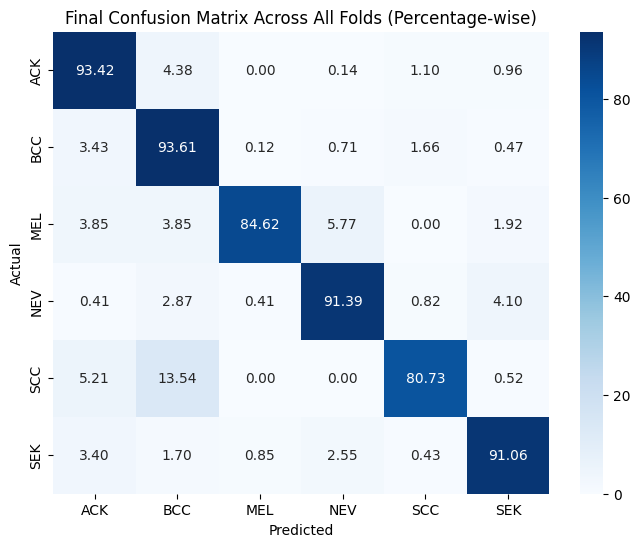

              precision    recall  f1-score   support

         ACK     0.9317    0.9342    0.9330       730
         BCC     0.9176    0.9361    0.9268       845
         MEL     0.9167    0.8462    0.8800        52
         NEV     0.9331    0.9139    0.9234       244
         SCC     0.8611    0.8073    0.8333       192
         SEK     0.9030    0.9106    0.9068       235

    accuracy                         0.9178      2298
   macro avg     0.9105    0.8914    0.9005      2298
weighted avg     0.9175    0.9178    0.9175      2298



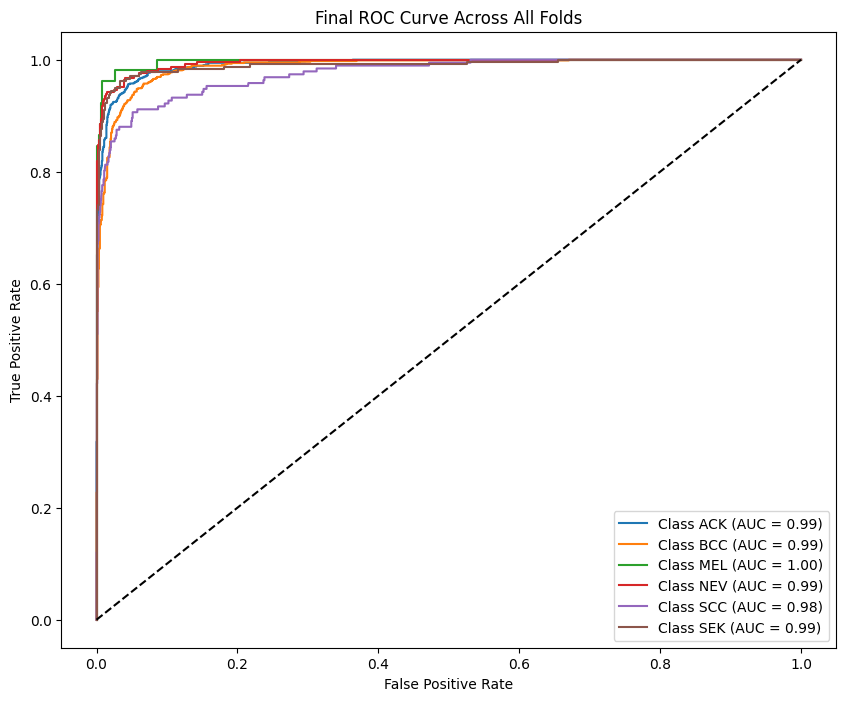

In [11]:

from sklearn.metrics import confusion_matrix
import numpy as np  # Ensure numpy is also imported
print("\n📊 Final Evaluation Across All Folds:")

cm = confusion_matrix(all_true_labels, all_pred_labels)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=base_dataset.class_to_idx.keys(), 
            yticklabels=base_dataset.class_to_idx.keys())

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix Across All Folds (Percentage-wise)")
plt.show()

class_report = classification_report(all_true_labels, all_pred_labels, target_names=base_dataset.class_to_idx.keys(), digits=4)
print(class_report)

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(np.array(all_true_labels) == i, np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(base_dataset.class_to_idx.keys())[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve Across All Folds")
plt.legend(loc="lower right")
plt.show()


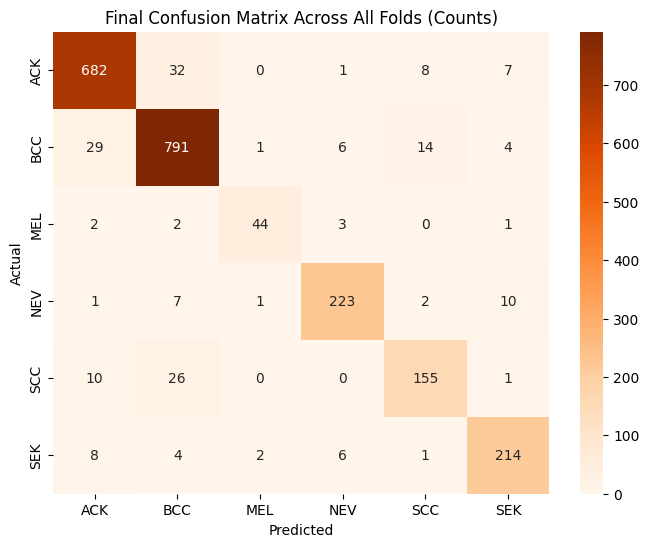

In [12]:
# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)

# Plot Number-based Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=base_dataset.class_to_idx.keys(), 
            yticklabels=base_dataset.class_to_idx.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix Across All Folds (Counts)")
plt.show()